In [1]:
import numpy as np
import glob
import sys
import imageio
import scipy.misc
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_files_train(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort(key= lambda x:int(x[11:x.index('_')]))
    return filenames

In [3]:
def get_files_test(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort(key= lambda x:int(x[10:x.index('.')]))
    return filenames

In [7]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return imageio.imread(path)

def resize_img(img_arr, target_dim=(50, 50)):
    """
    Resizes img represented as numpy array
    """
    return scipy.misc.imresize(img_arr, target_dim)

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

# Functions to load data

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files_train(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    if 'train' in folder:
        files = get_files_train(folder)
    elif 'test' in folder:
        files = get_files_test(folder)
    images = []
    count = 0

    for f in files:
        count += 1
        if count % 5000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
#         if count > 100:
#             break
        img_arr = get_img_array(f)/255.0
        images.append(img_arr)
#     X = tf.map_fn(lambda image: tf.image.per_image_standardization(image), images, tf.int32)
    X = np.array(images)
#     X = images
    return X

def get_train_data(data_root_path, suffix="train"):
    """
    Return X and y
    """
    train_data_path = data_root_path + suffix
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    np.save(filename, y)

In [8]:
# Load train data
data_root_path = 'data/'
# data_root_path = './cifar10-simple/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
# X_centered = (X_train - np.mean(X_train, axis=1)[:, np.newaxis])
# X_div = (X_centered / np.std(X_centered, axis=1)[:, np.newaxis])
# X_train = X_div
print('Train data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 5000/45000
Loaded 10000/45000
Loaded 15000/45000
Loaded 20000/45000
Loaded 25000/45000
Loaded 30000/45000
Loaded 35000/45000
Loaded 40000/45000
Loaded 45000/45000
Train data loading done


In [9]:
print(X_train.shape,y_train.shape)

(45000, 32, 32, 3) (45000,)


In [11]:
#Load test data
X_test = get_images(data_root_path + 'test')
# X_centered = (X_test - np.mean(X_test, axis=1)[:, np.newaxis])
# X_div = (X_centered / np.std(X_centered, axis=1)[:, np.newaxis])
# X_test = X_div
print('Test data loading done')

Loaded 5000/5000
Test data loading done


In [12]:
X_test.shape

(5000, 32, 32, 3)

In [13]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels,C,1)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return one_hot

In [14]:
Y_train = one_hot_matrix(y_train,10)

In [15]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32,shape=[None,n_H0,n_W0,n_C0],name='X')
    Y = tf.placeholder(tf.float32,shape=[None,n_y],name='Y')
    ### END CODE HERE ###
    
    return X, Y

In [16]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. 
    
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable('W1',[5,5,3,64],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    b1 = tf.get_variable('b1',[64],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[5,5,64,64],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    b2 = tf.get_variable('b2',[64],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2,
                 'b1':b1,
                 'b2':b2}
    
    return parameters

In [17]:
def norm(x):
    return tf.nn.lrn(x, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
def max_pool_2x2(x): return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [99]:
def forward_propagation_cost(X,Y,parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = conv2d(X,W1)+b1
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = norm(max_pool_2x2(A1))
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = conv2d(P1,W2)+b2
    # RELU
    A2 = norm(tf.nn.relu(Z2))
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = max_pool_2x2(A2)
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # 10 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    
    keep_prob = tf.placeholder(tf.float32,name='keep_prob')
    P2 = tf.nn.dropout(P2,keep_prob)
    Z3 = tf.contrib.layers.fully_connected(P2,10,activation_fn=None)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,labels=Y))
    ### END CODE HERE ###

    return Z3, keep_prob, cost

In [100]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size,:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:,:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [101]:
def model(X_train, Y_train, X_test, Y_test,test, learning_rate = 0.1,
          num_epochs = 100, minibatch_size = 64, print_cost = True, optimizer='GD',kp=1.0):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set
    Y_train -- test set
    X_test -- training set
    Y_test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    print(test.shape)
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3,keep_prob,cost = forward_propagation_cost(X,Y,parameters)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    #global_ = tf.Variable(tf.constant(0))  
    global_step = tf.Variable(0)
    lr = tf.train.exponential_decay(learning_rate,global_step,705,0.88,staircase=False)
    if optimizer == 'GD':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost,global_step=global_step)
    elif optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost,global_step=global_step)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
            
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a mfinibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={keep_prob:kp,X:minibatch_X,Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))

            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        save_predictions('ans-zz1749.npy',predict_op.eval({X: test,keep_prob:1.0}))
        # Calculate the correct predictions
        #train_accuracy = accuracy.eval({X: X_train, Y: Y_train,keep_prob:1.0})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test,keep_prob:1.0})
        #print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        return parameters

In [63]:
X_t,X_d,Y_t,Y_d = train_test_split(X_train,Y_train,test_size = 1./3)

(5000, 32, 32, 3)
Cost after epoch 0: 1.576328
Cost after epoch 1: 1.232955
Cost after epoch 2: 1.084014
Cost after epoch 3: 0.985320
Cost after epoch 4: 0.920782
Cost after epoch 5: 0.874631
Cost after epoch 6: 0.832032
Cost after epoch 7: 0.803521
Cost after epoch 8: 0.777315
Cost after epoch 9: 0.751912
Cost after epoch 10: 0.734312
Cost after epoch 11: 0.715096
Cost after epoch 12: 0.703006
Cost after epoch 13: 0.687472
Cost after epoch 14: 0.677818
Cost after epoch 15: 0.669790
Cost after epoch 16: 0.661827
Cost after epoch 17: 0.655696
Cost after epoch 18: 0.648646
Cost after epoch 19: 0.643950
Cost after epoch 20: 0.637064
Cost after epoch 21: 0.631884
Cost after epoch 22: 0.627788
Cost after epoch 23: 0.629842
Cost after epoch 24: 0.622781
Cost after epoch 25: 0.622186
Cost after epoch 26: 0.622082
Cost after epoch 27: 0.619738
Cost after epoch 28: 0.613510
Cost after epoch 29: 0.615428
Cost after epoch 30: 0.612295
Cost after epoch 31: 0.610751
Cost after epoch 32: 0.610924
Co

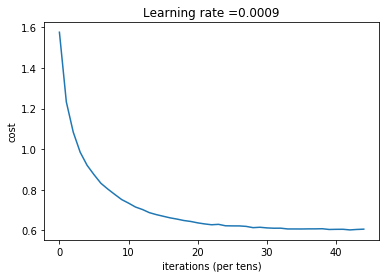

ResourceExhaustedError: OOM when allocating tensor with shape[15000,32,32,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_X_0_0/_69, W1/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_1/_73 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_73_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-102-4e65c4f9ab4d>", line 1, in <module>
    parameters = model(X_train,Y_train,X_d,Y_d,X_test,optimizer='adam',num_epochs=45,kp=0.8,learning_rate=0.0009)
  File "<ipython-input-101-3c5cd724aaf6>", line 43, in model
    Z3,keep_prob,cost = forward_propagation_cost(X,Y,parameters)
  File "<ipython-input-99-1c866b42caf6>", line 23, in forward_propagation_cost
    Z1 = conv2d(X,W1)+b1
  File "<ipython-input-17-6c92643fffa6>", line 5, in conv2d
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 725, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Users\Administrator\Anaconda2\envs\ipykernel_py3\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[15000,32,32,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_X_0_0/_69, W1/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_1/_73 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_73_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [102]:
parameters = model(X_train,Y_train,X_d,Y_d,X_test,optimizer='adam',num_epochs=45,kp=0.8,learning_rate=0.0009)

## My laptop tended to run OOM everytime when my batch size is big

In [103]:
loaded_y = np.load('ans-zz1749.npy')
print(loaded_y.shape)

(5000,)


In [104]:
set(list(loaded_y))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [105]:
dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [106]:
import pandas as pd

In [107]:
dict = {'id':range(5000),'label':[list(dict.keys())[list(dict.values()).index(x)] for x in loaded_y]}

In [108]:
data = pd.DataFrame(dict)

In [109]:
data.to_csv('ans2-zz1749.csv',index=False)

In [89]:
save_predictions('ans-zz1749.npy',data)

In [2]:
loaded_y = np.load('ans-zz1749.npy')
print(loaded_y.shape)

(5000, 2)


In [3]:
loaded_y

array([['horse', 0],
       ['frog', 1],
       ['automobile', 2],
       ...,
       ['truck', 4997],
       ['dog', 4998],
       ['dog', 4999]], dtype=object)

In [94]:
data.to_csv('ans-zz1749.csv',index=False)